In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import sys; sys.path.append('../')
from misc import h5file
from itertools import combinations
from pathlib import Path

import numpy as np
import jax.numpy as jnp
from numpy.random import default_rng
import scipy.io as sio
from scipy.optimize import curve_fit
from jaxfit import CurveFit
from statsmodels.api import OLS as SMOLS
import sympy
import pandas as pd

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

import pysindy as ps

from sympy import symbols, sympify, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from functools import partial

import yaml
from omegaconf import OmegaConf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    nobs2 = nobs / 2.0
    ssr = np.sum(np.abs(ground - prediction)**2)
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def BIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams

MAIN_SEED = 1234

In [2]:
data = sio.loadmat('../Datasets/KdV_sine_rep_big.mat')
u = (data['usol']).real
x = data['x'][0]
t = data['t'][0]
print("Domain shape:", u.shape)
dt = t[1]-t[0]
dx = x[1]-x[0]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

fp1 = "./IPI_output_files/KdV/PMS_data.h5"
fp2 = "./IPI_output_files/KdV/encoded_pde_names.yaml"
X_pre, best_subsets, un, y_pre = h5file(file_path=fp1, mode='r', return_dict=False)
encoded_pde_names = OmegaConf.load(fp2)['encoded_pde_names']

Domain shape: (512, 501)
['X_pre', 'best_subsets', 'un', 'y_pre']


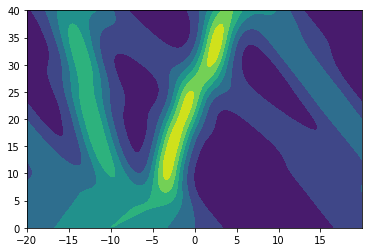

In [3]:
plt.contourf(X, T, u.T); plt.show()

In [4]:
def count_parameters(torch_model, onlyif_requires_grad=True):
    if onlyif_requires_grad:
        return sum(p.numel() for p in torch_model.parameters() if p.requires_grad)
    return sum(p.numel() for p in torch_model.parameters())

class Sine(nn.Module):
    def __init__(self, ):
        super(Sine, self).__init__()
    def forward(self, x):
        return torch.sin(x)

class TorchMLP(nn.Module):
    def __init__(self, dimensions, bias=True, activation_function=nn.Tanh(), bn=None, dropout=None):
        super(TorchMLP, self).__init__()
        # setup ModuleList
        self.model  = nn.ModuleList()
        for i in range(len(dimensions)-1):
            self.model.append(nn.Linear(dimensions[i], dimensions[i+1], bias=bias))
            if bn is not None and i!=len(dimensions)-2:
                self.model.append(bn(dimensions[i+1]))
                if dropout is not None:
                    self.model.append(dropout)
            if i==len(dimensions)-2: break
            self.model.append(activation_function)
        # weight init
        self.model.apply(self.xavier_init)

    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)

    def forward(self, x):
        for i, l in enumerate(self.model): 
            x = l(x)
        return x

In [5]:
class PhysicalConstraintCalculator(nn.Module):
    def __init__(self, symbolic_module, basic_vars, init_coefficients=None, learnable_coefficients=False):
        super(PhysicalConstraintCalculator, self).__init__()
        self.symbolic_module = symbolic_module
        self.basic_vars = basic_vars
        
        self.coefficients = init_coefficients
        self.learnable_coefficients = learnable_coefficients

        if self.coefficients is None:
            self.coefficients = torch.ones(len(symbolic_module.sympy())).float()
        else:
            self.coefficients = torch.tensor(data=self.coefficients).float()
        self.coefficients = nn.Parameter(self.coefficients).requires_grad_(self.learnable_coefficients)
        
        # printing
        if self.learnable_coefficients: print("Learnable coefficients:", self.coefficients)
        else: print("NOT learnable coefficients:", self.coefficients)
        print(symbolic_module.sympy())
        print("Basic variables:", self.basic_vars)

    def set_learnable_coefficients(self, learn):
        self.coefficients.requires_grad_(learn)
    
    def forward(self, input_dict):
        return self.symbolic_module(**input_dict)

class PINN(nn.Module):
    def __init__(self, solver, physics_calculator, lb, ub, ic_module=None):
        super(PINN, self).__init__()
        self.solver = solver
        self.physics_calculator = physics_calculator
        self.lb = lb
        self.ub = ub
        # must not be None if X_train_initial is not None but y_train_initial is None
        self.ic_module = ic_module
        
    def forward(self, x, t):
        return self.solver(self.input_normalize(torch.cat([x, t],  dim=-1)))

    def calculate_physics(self, x, t):
        u = self.forward(x, t)
        u_t = self.gradients(u, t)[0]
        u_1 = self.gradients(u, x)[0]
        u_11 = self.gradients(u_1, x)[0]
        u_111 = self.gradients(u_11, x)[0]
        physics = self.physics_calculator({nameof(u):u, 
                                           nameof(u_1):u_1, 
                                           nameof(u_11):u_11, 
                                           nameof(u_111):u_111})
        
        return u, u_t, physics
    
    def loss(self, x, t, y_input, X_train_initial=None, y_train_initial=None):
        u, u_t, physics = self.calculate_physics(x, t)
        coeff = self.physics_calculator.coefficients
        physics = (physics*coeff).sum(axis=-1)
        mse = F.mse_loss(u, y_input, reduction='mean')
        
        # initial condition (ic)
        if X_train_initial is not None:
            ic_u_pred = self.solver(self.input_normalize(X_train_initial))
            if y_train_initial is None:
                y_train_initial = self.ic_module(X_train_initial)
            ic_loss = F.mse_loss(ic_u_pred, y_train_initial, reduction='mean')
            mse = torch.add(mse, ic_loss)
            
        l_eq = F.mse_loss(u_t, physics, reduction='mean')
        return mse, l_eq
    
    def set_learnable_ic(self, flag):
        if self.ic_module is not None:
            self.ic_module.requires_grad_(flag)
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, 
                    grad_outputs=torch.ones(func.shape))

    def input_normalize(self, inp):
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [6]:
rng = default_rng(seed=0)
sampled_indices_x = np.array([i for i in range(len(x)) if i%2==0])
sampled_indices_t = np.array([i for i in range(len(t)) if i>=len(t)//2+1])
domain_dimension = len(sampled_indices_x), len(sampled_indices_t)

In [7]:
np.random.seed(MAIN_SEED);
torch.manual_seed(MAIN_SEED);

In [8]:
XX = X[sampled_indices_t, :][:, sampled_indices_x]
TT = T[sampled_indices_t, :][:, sampled_indices_x]
XXTT = XT[sampled_indices_x, :, :][:, sampled_indices_t, :]

In [9]:
X_train = np.hstack((XX.flatten()[:,None], TT.flatten()[:,None]))
y_train = un.T[sampled_indices_t, :][:, sampled_indices_x].flatten()[:,None]
lb = torch.tensor(X_train.min(axis=0)).float().requires_grad_(False)
ub = torch.tensor(X_train.max(axis=0)).float().requires_grad_(False)

In [10]:
# Converting to tensors
X_train_initial, y_train_initial = None, None
X_train = torch.tensor(X_train).float().requires_grad_(True)
y_train = torch.tensor(y_train).float().requires_grad_(False)
X_train.shape, y_train.shape

(torch.Size([64000, 2]), torch.Size([64000, 1]))

In [11]:
com = 2
init_coefficients = np.linalg.lstsq(X_pre[:, np.where(best_subsets[com-1]>0)[0]], 
                                    y_pre, rcond=None)[0].flatten()
mod, basic_vars = math_eval(encoded_pde_names[com-1], return_torch=True, split_by_addition=True)
init_coefficients, mod, basic_vars

(array([-0.90371676, -0.91031006]),
 SymPyModule(expressions=(u_111, u*u_1)),
 ['u', 'u_1', 'u_111'])

In [12]:
# unique to this KS PDE example
class ManualICModule(nn.Module):
    def __init__(self, *expressions):
        super(ManualICModule, self).__init__()
        raise NotImplementedError
    def forward(self, x_initial):
        raise NotImplementedError

class ICModule(nn.Module):
    def __init__(self, *expressions):
        super(ICModule, self).__init__()
        self.mod = sympytorch.SymPyModule(expressions=expressions)
    def forward(self, x_initial):
        return self.mod(x0=x_initial[:, 0])

In [13]:
activation_function = nn.Tanh()
n_nodes = 5 # 5, 10 or 50
solver = TorchMLP([2,n_nodes,n_nodes,n_nodes,n_nodes,1], bn=None, 
                  activation_function=activation_function)

physics_calculator = PhysicalConstraintCalculator(symbolic_module=mod, 
                                                  basic_vars=basic_vars, 
                                                  init_coefficients=init_coefficients, 
                                                  learnable_coefficients=True)

# ic_module = ICModule(sympify(equation.sympy_format)))
# sym_x0 = symbols("x0")
# expression = sympy.cos(recovered_params[0]*sym_x0)*(recovered_params[2]+sympy.sin(recovered_params[1]*sym_x0))
# ic_module = ICModule(expression)

Learnable coefficients: Parameter containing:
tensor([-0.9037, -0.9103], requires_grad=True)
[u_111, u*u_1]
Basic variables: ['u', 'u_1', 'u_111']


In [14]:
pinn = PINN(solver, physics_calculator, 
            lb, ub)

In [15]:
def closure(return_tuple=False):
    if torch.is_grad_enabled():
        lbfgs.zero_grad()
    l1, l2 = pinn.loss(X_train[:, 0:1], X_train[:, 1:2], y_train, 
                       X_train_initial, y_train_initial)
    l = torch.add(l1, l2)
    if l.requires_grad: 
        l.backward()
    if not return_tuple:
        return l
    return l1, l2


ic_flag = False; coeff_flag = True
if ic_flag: y_train_initial= None
pinn.set_learnable_ic(ic_flag)
pinn.physics_calculator.set_learnable_coefficients(coeff_flag)
lbfgs = torch.optim.LBFGS(pinn.parameters(), 
                          lr=0.1, max_iter=500, max_eval=500, history_size=300, 
                          line_search_fn='strong_wolfe')
epochs = 500
best_lt = 1e6; patience = 0
pinn.train()

for i in range(epochs):
    lbfgs.step(closure)

    # calculate the loss again for monitoring
    if (i%50)==0:
        l1, l2 = closure(return_tuple=True)
        l1, l2 = l1.item(), l2.item()
        lt = l1+l2
        if lt < best_lt: best_lt = lt
        else: patience += 1
        print("Epoch {}: ".format(i), l1, l2)

    if patience > 0:
        break

Epoch 0:  0.011682581156492233 0.0025318446569144726
Epoch 50:  0.004303900524973869 0.0004727677733171731
Epoch 100:  0.004303900524973869 0.0004727677733171731


In [16]:
### Indecisive ACS ### -> BIC is better!!! (more regularization)
pinn.eval()
pred = pinn(X_train[:, 0:1], X_train[:, 1:2]).detach().numpy()
base = count_parameters(pinn.solver)
assert com == count_parameters(pinn.physics_calculator, False)
print("# base:", base)
print(BIC(pred, y_train.detach().numpy(), com))
print(BIC(pred, y_train.detach().numpy(), base+count_parameters(pinn.physics_calculator, False)))

# base: 111
-167040.67998397726
-165812.28312575733


In [17]:
validation_indices_x = np.array([i for i in range(len(x)) if i%2==1])
validation_indices_t = np.array([i for i in range(len(t)) if i<len(t)//2+1])

In [18]:
val_pred = pinn(torch.tensor(X[validation_indices_t, :][:, validation_indices_x].flatten()[:,None]).float(), 
                torch.tensor(T[validation_indices_t, :][:, validation_indices_x].flatten()[:,None]).float()).detach().numpy()
y_val = un.T[validation_indices_t, :][:, validation_indices_x].flatten()[:,None]
print(BIC(val_pred, y_val, com))
print(BIC(val_pred, y_val, base+count_parameters(pinn.physics_calculator, False)))

245841.282478956
247070.12245153688


In [19]:
assert (base+count_parameters(pinn.physics_calculator, False)) == count_parameters(pinn)